<a href="https://colab.research.google.com/github/HoTrungQuan2004/ParkingAreaManage/blob/main/Train_License_plate_detection_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install tensorflow --quiet
!pip install tensorflow.keras --quiet

In [51]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [3]:
from google import colab
colab.drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [52]:
# ⚙️ Cấu hình ảnh
IMG_SIZE = 96
ORIG_W, ORIG_H = 640, 410  # ảnh gốc gán nhãn pixel

# 📁 Thư mục dataset gốc
DATASET_DIR = "/content/drive/MyDrive/license_plate/dataset/plate_detection"

# ✅ Hàm resize giữ tỉ lệ (letterbox resize)
def letterbox_resize(img, target_size):
    h, w = img.shape[:2]
    scale = min(target_size/w, target_size/h)
    nw, nh = int(w*scale), int(h*scale)
    img_resized = cv2.resize(img, (nw, nh))
    top = (target_size - nh) // 2
    bottom = target_size - nh - top
    left = (target_size - nw) // 2
    right = target_size - nw - left
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(128,128,128))
    return img_padded, scale, left, top

# ✅ Load data từ folder train/val/test

def load_dataset(folder_path):
    img_dir = os.path.join(folder_path, 'images')
    label_dir = os.path.join(folder_path, 'labels')

    X, y = [], []

    for img_path in glob(os.path.join(img_dir, "*.jpg")):
        label_path = os.path.join(label_dir, os.path.basename(img_path).replace('.jpg', '.txt'))
        if not os.path.exists(label_path):
            continue

        img = cv2.imread(img_path)
        img_resized, scale, pad_x, pad_y = letterbox_resize(img, IMG_SIZE)

        with open(label_path) as f:
            line = f.readline().strip().split()
            if len(line) != 5:
                continue
            _, x, y_, w, h = map(float, line)  # pixel format gốc (640x410)

            # Scale bbox theo resize
            x *= scale
            y_ *= scale
            w *= scale
            h *= scale

            # Dịch bbox theo padding
            x += pad_x
            y_ += pad_y

            # Normalize về [0,1] theo size ảnh 96x96
            x /= IMG_SIZE
            y_ /= IMG_SIZE
            w /= IMG_SIZE
            h /= IMG_SIZE

            X.append(img_resized / 255.0)
            y.append([x, y_, w, h])

    return np.array(X), np.array(y)

# ✅ Load dữ liệu
X_train, y_train = load_dataset(os.path.join(DATASET_DIR, 'train'))
X_val, y_val = load_dataset(os.path.join(DATASET_DIR, 'val'))
X_test, y_test = load_dataset(os.path.join(DATASET_DIR, 'test'))

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

# ✅ Model mạnh hơn
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4)  # [x, y, w, h] đã normalize
])

model.compile(optimizer='adam', loss='huber', metrics=['mae'])
model.summary()

Train: (1056, 96, 96, 3) (1056, 4)
Val: (300, 96, 96, 3) (300, 4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,453,188 (9.36 MB)

 Trainable params: 2,453,188 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# ✅ Huấn luyện
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 410ms/step - loss: 0.0875 - mae: 0.2587 - val_loss: 0.0054 - val_mae: 0.0758
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - loss: 0.0050 - mae: 0.0760 - val_loss: 0.0028 - val_mae: 0.0554
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - loss: 0.0039 - mae: 0.0674 - val_loss: 0.0014 - val_mae: 0.0373
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 393ms/step - loss: 0.0034 - mae: 0.0631 - val_loss: 0.0023 - val_mae: 0.0503
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/step - loss: 0.0028 - mae: 0.0569 - val_loss: 0.0019 - val_mae: 0.0467
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 426ms/step - loss: 0.0025 - mae: 0.0537 - val_loss: 0.0011 - val_mae: 0.0350
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 380ms/step - loss: 0.0023 - mae: 0.0514 - val_loss: 9.2228e-04 - val_mae: 0.0308
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 343ms/step - loss: 0.0023 - mae: 0.0498 - val_loss: 9.4657e-04 - val_mae: 0.0300
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 43

In [103]:
# ✅ Lưu model (cho train tiếp hoặc chạy trên colab)
model.save("plate_detector_pixel96.h5")

In [99]:
# ✅ Kiểm tra bbox lệch (tự động highlight nếu tâm bbox nằm quá thấp)
def show_bbox(i, X, y):
    img = (X[i] * 255).astype(np.uint8).copy()
    bbox = y[i]
    x1 = int((bbox[0] - bbox[2]/2) * IMG_SIZE)
    y1 = int((bbox[1] - bbox[3]/2) * IMG_SIZE)
    x2 = int((bbox[0] + bbox[2]/2) * IMG_SIZE)
    y2 = int((bbox[1] + bbox[3]/2) * IMG_SIZE)
    color = (0,255,0) if bbox[1] < 0.8 else (0,0,255)
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 1)
    plt.imshow(img)
    plt.title(f"bbox = {np.round(bbox,2)}")
    plt.axis('off')
    plt.show()

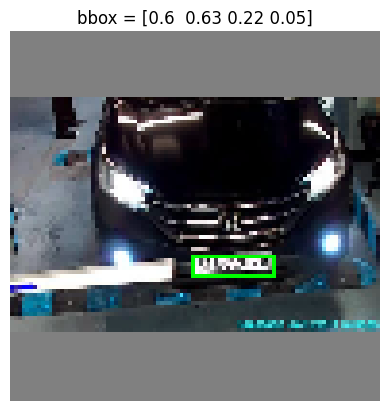

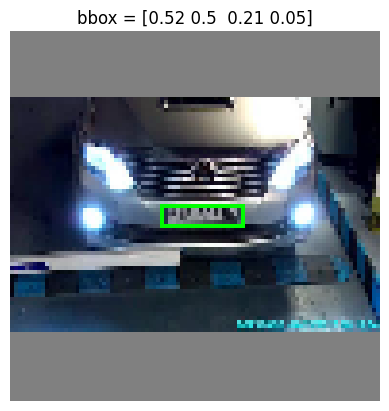

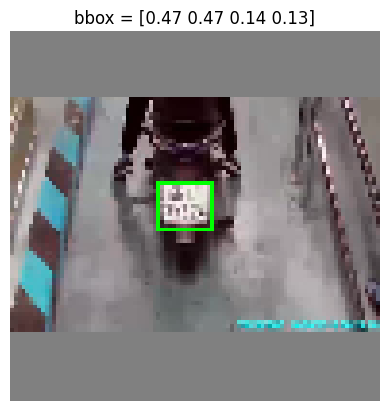

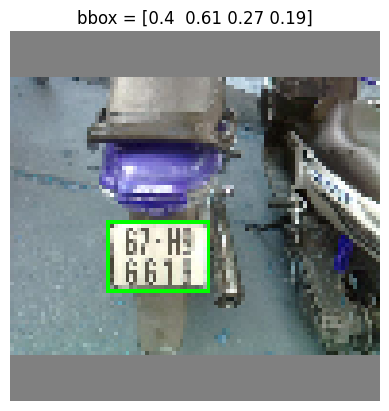

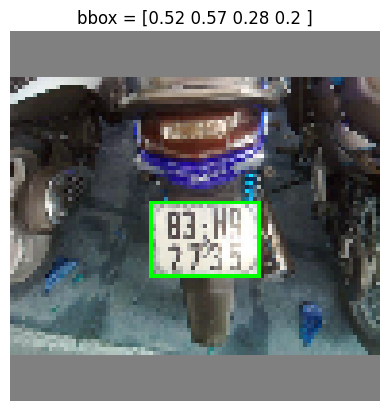

In [102]:
# 🧪 Ví dụ kiểm tra ngẫu nhiên
import random
for _ in range(5):
    show_bbox(random.randint(0, len(X_train) - 1), X_train, y_train)

In [59]:
#test model
X_test, y_test = load_data("/content/drive/MyDrive/license_plate/dataset/plate_detection/test")
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.0056 - mae: 0.0802
Test loss: [0.006270076613873243, 0.08554953336715698]


In [60]:
#show label (to check)
for i in range(5):
    print(y_train[i])

[0.47578125 0.52916667 0.3578125  0.265625  ]
[0.6703125  0.75286458 0.196875   0.0453125 ]
[0.4953125  0.52239583 0.25       0.0625    ]
[0.52421875 0.50442708 0.2359375  0.0734375 ]
[0.53046875 0.57239583 0.2265625  0.19375   ]


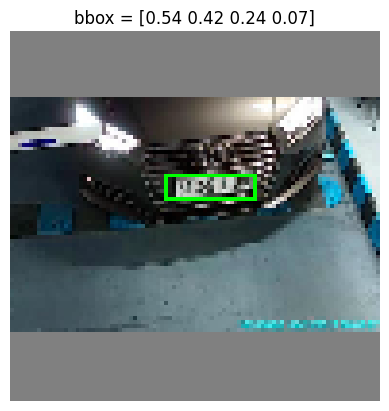

In [98]:
# check
import matplotlib.pyplot as plt
from numpy import random

def show_bbox_sample(i):
    img = (X_train[i] * 255).astype(np.uint8).copy()
    bbox = y_train[i]
    x1 = int((bbox[0] - bbox[2]/2) * 96)
    y1 = int((bbox[1] - bbox[3]/2) * 96)
    x2 = int((bbox[0] + bbox[2]/2) * 96)
    y2 = int((bbox[1] + bbox[3]/2) * 96)
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 1)
    plt.imshow(img)
    plt.title(f"bbox = {np.round(bbox, 2)}")
    plt.axis('off')
    plt.show()

x = random.randint(100)
show_bbox_sample(x)

In [ ]:
#convert into .tflite (cho thiết bị nhúng IoT, android app,...)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("plate_detector.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpww4p2gv_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140268140304080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140268140304848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140268140306576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140268140304272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140268140306960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140268140307152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140268140304464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140268140306000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140268140309072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140268140310032: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
!xxd -i plate_detector.tflite > plate_model.h